# Example: Probabilistic Roadmap (PRM*) Sampling-Based Motion Planning

In [1]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
import time
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from shapely import box
from shapely.geometry import Polygon, Point
import heapq

from exercises.utils import Workspace2D, Node

In [2]:
def dijkstra(start_node, edges):
    visited = set()
    Q = [(0, start_node)]
    while Q:
        current_cost, current_node = heapq.heappop(Q)
        if current_node in visited:
            continue
        visited.add(current_node)
        for neighbor, edge_cost in edges[current_node]:
            if neighbor in visited:
                continue
            new_cost = current_cost + edge_cost
            if new_cost < neighbor.cost:
                neighbor.cost = new_cost
                neighbor.parent = current_node.idx
                heapq.heappush(Q, (new_cost, neighbor))

class PRMStar(object):
    """
    Represents a motion planning problem to be solved using the PRM* algorithm
    """
    def __init__(self, workspace: Workspace2D, x_init, x_goal):
        self.workspace = workspace
        self.x_init = np.array(x_init)                  # initial state
        self.x_goal = np.array(x_goal)                  # goal state
        self.V = []             # list of Nodes in the tree
        self.path = None        # the final path as a list of states

    def plot_problem(self):
        """
        Plot the workspace, start, and goal points
        """
        self.workspace.plot()
        plt.scatter([self.x_init[0], self.x_goal[0]], [self.x_init[1], self.x_goal[1]], color="green", s=30, zorder=10)
        plt.annotate(r"$x_{init}$", self.x_init[:2] + [.2, 0], fontsize=16)
        plt.annotate(r"$x_{goal}$", self.x_goal[:2] + [.2, 0], fontsize=16)

    def plot_tree(self, **kwargs):
        for node in self.V:
            if node.parent is not None:
                parent_node = self.V[node.parent]
                x = [node.point[0], parent_node.point[0]]
                y = [node.point[1], parent_node.point[1]]
                plt.plot(x, y, linewidth=1, color="blue", alpha=0.2)

    def plot_path(self, **kwargs):
        if len(self.path) > 1:
            x = [node.point[0] for node in self.path]
            y = [node.point[1] for node in self.path]
            plt.plot(x, y, **kwargs)

    def solve(self, max_nodes=500, eta=1.0):
        """
        Constructs a PRM rooted at self.x_init with the aim of producing a
        obstacle-free trajectory from self.x_init to self.x_goal.

        Inputs:
            max_nodes: maximum number of nodes to create
            eta: A scaling factor used to determine the connection radius
        Output:
            Boolean, true if a valid path was found
        """
        start_node = Node(self.x_init, parent=None, cost=0, idx=0)
        goal_node = Node(self.x_goal, idx=1)
        self.V = [start_node, goal_node] # reset the list of nodes

        # Sample and add to V
        for _ in range(max_nodes):
            rand_point = self.workspace.random_sample()
            if self.workspace.is_free(rand_point):
                self.V.append(Node(rand_point, idx=len(self.V)))
        N = len(self.V)

        # Compute connection radius and distance matrix between
        # points
        mu = self.workspace.width * self.workspace.height
        for obstacle in self.workspace.obstacles:
            mu -= obstacle.area
        r = eta * np.sqrt(2 * mu / np.pi * np.log(N) / N)
        points = np.array([v.point for v in self.V])
        distances = distance_matrix(points, points)
        
        # Create adjacency list for the graph, each edge for a node consists of
        # the neighbor node and the cost (i.e. distance) to cross the edge
        edges = {v: [] for v in self.V}
        for i, node in enumerate(self.V):
            neighbor_nodes = [self.V[j] for j in range(i+1, N) if distances[i, j] < r and self.workspace.is_free_line(node.point, self.V[j].point)]
            for neighbor in neighbor_nodes:
                edges[node].append((neighbor, distances[i, self.V.index(neighbor)]))
                edges[neighbor].append((node, distances[self.V.index(neighbor), i]))  # Because the graph is undirected
        
        # Solve using Dijkstra's algorithm
        dijkstra(start_node, edges)

        # Reconstruct path if it exists
        self.path = []
        if goal_node.parent is None:
            print("Solution not found!")
            return np.inf
        current = goal_node
        while current.parent is not None:
            self.path.append(current)
            current = self.V[current.parent]
        self.path.append(current)
        self.path.reverse()
        
        # Plot the results
        self.plot_problem()
        self.plot_tree(color="blue", linewidth=.5, label="RRT tree", alpha=0.5)
        self.plot_path(color="green", linewidth=2, label="Solution path")  
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, ncol=3)
        plt.scatter([node.point[0] for node in self.V], [node.point[1] for node in self.V])

        return goal_node.cost

Run the code below to generate a PRM* solution.

Time: 0.077 s, Path Cost: 15.345


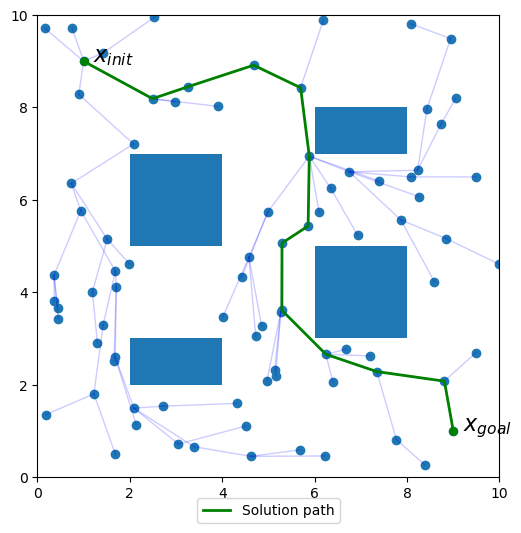

In [3]:
# Create workspace
workspace = Workspace2D(10, 10)
obstacles = [box(2, 2, 4, 3), box(6, 7, 8, 8), box(6, 3, 8, 5), box(2, 5, 4, 7)]
workspace.set_obstacles(obstacles)

# Define start and goal positions
x_init = [1,9]
x_goal = [9,1]
prm = PRMStar(workspace, x_init, x_goal)

# Solve the problem
start_time = time.perf_counter()
cost = prm.solve(100)
elapsed_time = time.perf_counter() - start_time
print(f"Time: {elapsed_time:.3f} s, Path Cost: {cost:.3f}")

Now, try running increasing the number of nodes and resolving the problem and see how the cost will change.

Time: 0.935 s, Path Cost: 12.585


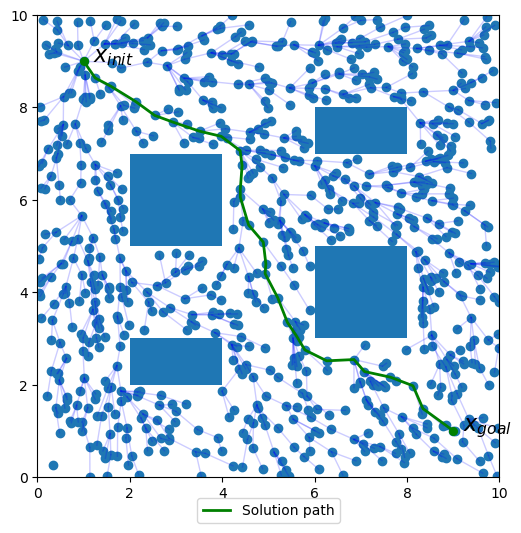

In [4]:
# Solve the problem
start_time = time.perf_counter()
cost = prm.solve(1000)
elapsed_time = time.perf_counter() - start_time
print(f"Time: {elapsed_time:.3f} s, Path Cost: {cost:.3f}")